# Welcome to our Machine Learning Project for IT1244

We are group <group number> and we would like to investigate the effects of using bigrams and trigrams in the accuracy of predicting the sentiments of movie reviews. 

## Why bigrams and trigrams

The concept of using N-grams is a fundamental practice in the realm of Natural Language Processing. N-grams refer to a contiguous sequences of n items in a body of text grouped together. More specifically, bigrams refer to pairs of consecutive words while trigrams refer to groups of 3 consecutive words. N-grams are used to capture context, allowing machines to accurately accomplish tasks such as generating texts and predicting sentiments.

It is universally accepted that trigrams perform better than bigrams, mostly due to trigrams being able to capture more contextual information. Trigrams capture the information of the 2 preceding words, while bigrams can only capture the information of 1 preceding word.

### Our approach

We decided to use feed-forward neural networks as our training model due to its ability to automatically learn features, and its potential for capturing complex patterns within the reviews.

First, let us import some modules to help us train our model. We set manual seed to be 0 (or could be any other value) to ensure that the dropout values are consistent in the later part of training the model.


In [41]:
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)
torch.cuda.manual_seed(0)


## Data pre-processing

For our dataset, we decided to use the dataset that was provided to us. This dataset consists of 25000 positive reviews and 25000 negative reviews.

Because the dataset is in text format, it is extremely difficult to identify missing/rare values. As such we took every word that was given to us and passed them into the model for training. We decided to split the training set and test set by 80% and 10% respectively, using sklearn's `train_test_split()`.

In [42]:
from sklearn.model_selection import train_test_split
from pathlib import Path

folder_path_negative = Path("./data/neg")
folder_path_positive = Path("./data/pos")

X_list = []
y_list = []
for file_path in folder_path_negative.iterdir():
    with open(file_path, 'r') as f:
        X_list.append(f.read())
        y_list.append('0')

for file_path in folder_path_positive.iterdir():
    with open(file_path, 'r') as f:
        X_list.append(f.read())
        y_list.append('1')

X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, test_size=0.2, random_state=42)

with open('x_train.txt', 'w') as f:
    for x in X_train:
        f.write(x)
        f.write('\n')

with open('x_test.txt', 'w') as f:
    for x in X_test:
        f.write(x)
        f.write('\n')

with open('y_train.txt', 'w') as f:
    for y in y_train:
        f.write(y)
        f.write('\n')

with open('y_test.txt', 'w') as f:
    for y in y_test:
        f.write(y)
        f.write('\n')



## First Step: Setting up the Dataset class

Pytorch has a dataset class that allows us to use data in batches, rather than using the data wholesale. We want to implement a `SentDataset` class that inherits the property of the Dataset class in Pytorch.


Some more information about the class methods:
- `generate_bigrams` generates a list of bigrams from every movie review

- `generate_trigrams` generates a list of trigrams

- Because models only recognise vectors, we need to first convert words into vectors.
    - We first identify all unique ngrams (bigrams or trigrams) and add them to our dictionary, giving them each a unique index from 0 to n - 1, where n is the total number of unique ngrams.
    
    - During the `__getItem__` method, we retrieve the indices of all the ngrams in a text from the dictionary, and convert them into a tensor.

In [43]:
class SentDataset(Dataset):
    """
    A pytorch dataset class that accepts a text path, and optionally label path (only during training phase) and
    a vocabulary (only during testing phase). This class holds all the data and implement
    a __getitem__ method to be used by a Python generator object or other classes that need it.

    """
    def __init__(self, train_path, type, label_path=None, vocab=None):
        """
        Read the content of vocab and text_file
        Args:
            vocab (string): Path to the vocabulary file.
            text_file (string): Path to the text file.
            type (string): Specify if model is trained using bigrams or trigrams
        """
        self.label_path = label_path
        self.type = type
        self.texts = []
        self.labels = []
        with open(train_path, encoding='utf-8') as f:
            self.texts = [line for line in f.readlines() if line.strip()]
        if label_path:
            with open(label_path, encoding='utf-8') as f:
                self.labels = [line for line in f.readlines() if line.strip()]
        if not vocab:
            self.vocabulary = {}
            curr_idx = 0
            for text in self.texts:
                ngrams = self.generate_tokens(text, type)
                for ngram in ngrams:
                    if ngram in self.vocabulary:
                        continue
                    else:
                        self.vocabulary[ngram] = curr_idx
                        curr_idx += 1
        else: 
            self.vocabulary = vocab

    def generate_unigrams(self, text):
        tokens = text.split()
        return tokens
        

    def generate_bigrams(self, text):
        """
        Function to generate bigrams from a text (string)
        Bigrams are defined as a grouping of a text into a list of 2 consecutive words
        """
        tokens = text.split()
        bigrams = []
        for i in range(len(tokens) - 1):
            bigram = f"{tokens[i]} {tokens[i + 1]}"
            bigrams.append(bigram)
        return bigrams
    
    def generate_trigrams(self, text):
        """
        Function to generate bigrams from a text (string)
        Bigrams are defined as a grouping of a text into a list of 3 consecutive words
        """
        tokens = text.split()
        trigrams = []
        for i in range(len(tokens) - 2):
            trigram = f"{tokens[i]} {tokens[i + 1]} {tokens[i + 2]}"
            trigrams.append(trigram)
        return trigrams
    
    def generate_tokens(self, text, type):
        """
        Function to determine if bigrams or trigrams should be generated, depending on type specified
        """
        if type == "unigram":
            return self.generate_unigrams(text)
        elif type == "bigram":
            return self.generate_bigrams(text)
        else: 
            return self.generate_trigrams(text)


    def vocab_size(self):
        """
        A function to inform the vocab size. The function returns two numbers:
            num_vocab: size of the vocabulary
        """
        return len(self.vocabulary)

    
    def __len__(self):
        """
        Return the number of instances in the data
        """
        return len(self.texts)

    def __getitem__(self, i):
        """
        Return the i-th instance in the format of:
            (text, label)
        Text and label is encoded according to the vocab (word_id).

        """
        if self.label_path: # training
            text = self.texts[i]
            label = int(self.labels[i])
            indices = []
            ngrams_in_text = self.generate_tokens(text, self.type)
            for ngram in ngrams_in_text:
                index = self.vocabulary.get(ngram)
                indices.append(index)
    
            indices_tensor = torch.tensor(indices)
            return indices_tensor, label
        
        else: # testing 
            text = self.texts[i]
            indices = []
            ngrams_in_text = self.generate_tokens(text, self.type)
            for ngram in ngrams_in_text:
                if ngram in self.vocabulary:
                    index = self.vocabulary.get(ngram)
                    indices.append(index)
            indices_tensor = torch.tensor(indices)
            return indices_tensor

## Second step: Setting up the model

As mentioned earlier, we decided to use feed-forward neural networks as our model framework. We have also come up with custom layers to pass our data through.

To further map sparse categorical variables such as word indices into continuous vectors, we use an embedding layer. We first initialise an embedding matrix, where after passing our list of ngrams into it, we will obtain an embedding vector that would accurately represent the ngrams' relationship with other ngrams. This is a form of feature representation, as the embedding layer will assign features to each ngram as it learns through backpropagation.

We then take the mean of the obtained embedding vector to feed forward into the subsequent layers.

These layers are (in order):
- an embedding layer that takes in the number of vocabulary to place a limit on the number of embeddings needed, as well as the embedding dimension, which is a hyperparameter.

- a first linear layer with output dimension, which is a parameter.

- a RELU activation function after the first linear layer

- a dropout layer with hyperparameter probability to reduce overfitting

- a second linear layer with output dimension 1

- a final sigmoid layer to output values 0 to 1, representing the probability of the movie review to be positive (1) or negative (0)


In [44]:
class Model(nn.Module):
    """
    Define your model here
    """
    def __init__(self, num_vocab):
        super().__init__()
        # define model attributes 
        self.embedding_dim = 8 # define embedding dimensions (hyperparameter)
        self.embedding = nn.Embedding(num_vocab, self.embedding_dim) # transform words into embeddings
        self.first_layer_dim = 24 # define first layer dimension (hyperparameter)
        self.linear_layer_1 = nn.Linear(self.embedding_dim, self.first_layer_dim) # linear layer
        self.relu = nn.ReLU() # ReLU activation function
        self.dropout = nn.Dropout(0.2) # dropout of 0.2 probability (hyperparameter) to reduce overfitting
        self.linear_layer_2 = nn.Linear(self.first_layer_dim, 1) # last linear layer
        self.sigmoid = nn.Sigmoid() # Sigmoid function to determine probabilities


    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = self.linear_layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_layer_2(x)
        x = self.sigmoid(x)

        return x

## Third step: Define a collator function

A collator function is used during the loading of batches of data during testing. This function returns a pair of tensors that represent the texts in the batch, as well as the labels of the texts.

Note that the dimensions of the text may differ from each other, so we padded the tensor with zeros to ensure that we can fit multiple texts of different sizes into one big tensor.

In [45]:
def collator(batch):
    """
    A function that receives a list of (text, label) pair
    and return a pair of tensors:
        texts: a tensor that combines all the text in the mini-batch, pad with 0
        labels: a tensor that combines all the labels in the mini-batch
    """
    if len(batch[0]) == 2:
        texts, labels = zip(*batch)
        # convert text indices to tensor
        texts_tensor = nn.utils.rnn.pad_sequence([text for text in texts], batch_first=True, padding_value=0)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        return texts_tensor, labels_tensor
    else:
        texts_tensor = nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)
        return texts_tensor

## Fourth step: Define the training function

Next, we would have to train the model. We used the `DataLoader` class provided by pytorch to load data in batches, with the help of the `collator` function we just initialised.

The loss function we have chosen is the Binary Cross Entropy Loss, as the labels are in binary form (0 or 1). The optimiser we chose is Adam's optimiser.

In each epoch, we will train the model using batches of data. We would then do forward propagation of the data, calculate the loss, and finally update the weights of the model.

After training, we would save the state of the model and the optimizer into a checkpoint file. This file is to be used later during testing.

In [46]:
def train(model, dataset, batch_size, learning_rate, num_epoch, device='cpu', model_path=None, loss_history=None):
    """
    Complete the training procedure below by specifying the loss function
    and optimizers with the specified learning rate and specified number of epoch.
    
    """
    # instantiate the data loader which loads data in batches
    data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collator, shuffle=True)

    # loss function is Binary Cross Entropy Loss
    criterion = nn.BCELoss()
    # optimiser is Adam's optimiser
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start = datetime.datetime.now()
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        for step, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            texts = data[0].to(device)
            labels = data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # do forward propagation
            outputs = model(texts)

            # calculate the loss
            loss = criterion(outputs, labels.reshape((outputs.shape[0], 1)))

            # do backward propagation to update the weights
            loss.backward()

            # do the parameter optimization
            optimizer.step()

            # calculate running loss value for non padding
            running_loss += loss.item()

            # print loss value every 100 iterations and reset running loss
            if step % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, step + 1, running_loss / 100))
                loss_history['train'].append(running_loss / 100)
                running_loss = 0.0

    end = datetime.datetime.now()
    
    # make the checkpoint of the model and save it to the model path
    # contains current state of the model, optimiser, number of epochs, and current vocabulary
    checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': num_epoch,
        'vocab': dataset.vocabulary
    }
    torch.save(checkpoint, model_path)

    print('Model saved in ', model_path)
    print('Training finished in {} minutes.'.format((end - start).seconds / 60.0))

## Fifth step: define the testing function

With the same logic as the training function, we load batches from the test dataset to predict their labels. Using 0.5 as the threshold, results that are 0.5 and above would be a positive sentiment, while those below 0.5 would be a negative sentiment.

In [47]:
def test(model, dataset, thres=0.5, device='cpu'):
    model.eval()
    data_loader = DataLoader(dataset, batch_size=20, collate_fn=collator, shuffle=False)
    labels = []
    with torch.no_grad():
        for data in data_loader:
            texts = data.to(device)
            results = model(texts)
            pred_labels = (results > thres).int().tolist()
            pred_labels = sum(pred_labels, [])
            labels.extend(pred_labels)

    return [str(x) for x in labels]

## Almost there

Let's initialise variables useful to us such as the path to training dataset, the testing dataset, and the model checkpoint.

In [48]:
x_train = "x_train.txt"
x_test = "x_test.txt"
y_train = "y_train.txt"
y_test = "y_test.txt"
output_path_bigram = "out_bigram.txt"
model_checkpoint_bigram = "model_bigram.pt"

## Finally: train the model!

We have now initialised all the functions that we needed. Now it is time to run the code. 

During the training phase, we need to initialise the SentDataset model with the path of the training dataset and the labels. Then, we pass the number of vocab as a parameter into the model. We specify hyper-parameters of such as batch size, learning rate, and number of epoch. 

The function below trains the model using `bigrams`.

## Test the model

Now that we have finished training the model, it is time to test the model. 

We first load the model checkpoint saved during the testing phase. Similarly to our training phase, we pass our testing dataset into our SentDataset class. Then, we load the model using the checkpoint saved.

Following which, we test the model using the testing dataset, outputting the predicted labels into the output path as specified earlier.

The function below trains the model using `bigrams`.

In [49]:
if torch.cuda.is_available():
    device_str = 'cuda:{}'.format(0)
else:
    device_str = 'cpu'
    device = torch.device(device_str)

dataset = SentDataset(x_train, "bigram", y_train)
num_vocab = dataset.vocab_size()
model_bigram = Model(num_vocab).to(device)

# specify hyper-parameters
batch_size = 48
learning_rate = 0.01
num_epochs = 10

# Loss history
loss_history = { 'train': [] }

train(model_bigram, dataset, batch_size, learning_rate, num_epochs, device, model_checkpoint_bigram, loss_history)

[1,   100] loss: 0.695
[1,   200] loss: 0.693
[1,   300] loss: 0.678
[1,   400] loss: 0.537
[1,   500] loss: 0.405
[1,   600] loss: 0.374
[1,   700] loss: 0.351
[1,   800] loss: 0.341
[2,   100] loss: 0.097
[2,   200] loss: 0.084
[2,   300] loss: 0.091
[2,   400] loss: 0.091
[2,   500] loss: 0.088
[2,   600] loss: 0.072
[2,   700] loss: 0.076
[2,   800] loss: 0.065
[3,   100] loss: 0.011
[3,   200] loss: 0.011
[3,   300] loss: 0.005
[3,   400] loss: 0.014
[3,   500] loss: 0.008
[3,   600] loss: 0.015
[3,   700] loss: 0.004
[3,   800] loss: 0.008
[4,   100] loss: 0.008
[4,   200] loss: 0.014
[4,   300] loss: 0.002
[4,   400] loss: 0.004
[4,   500] loss: 0.009
[4,   600] loss: 0.002
[4,   700] loss: 0.002
[4,   800] loss: 0.002
[5,   100] loss: 0.003
[5,   200] loss: 0.001
[5,   300] loss: 0.031
[5,   400] loss: 0.002
[5,   500] loss: 0.001
[5,   600] loss: 0.007
[5,   700] loss: 0.001
[5,   800] loss: 0.001
[6,   100] loss: 0.001
[6,   200] loss: 0.004
[6,   300] loss: 0.006
[6,   400] 

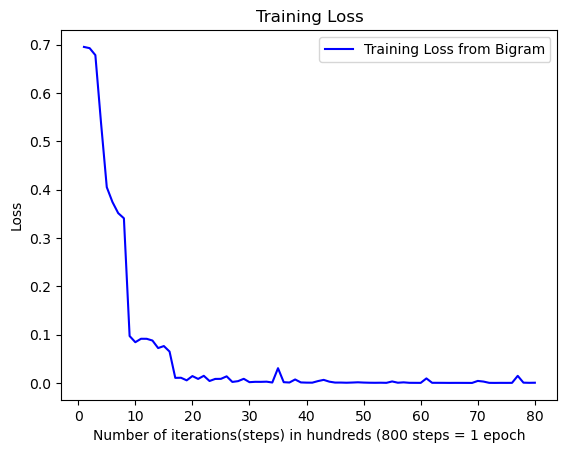

In [50]:
# print(loss_history)

import matplotlib.pyplot as plt

x_values = range(1,len(loss_history['train'])+1)
plt.plot(x_values, loss_history['train'], 'b', label="Training Loss from Bigram")
plt.title("Training Loss")
plt.xlabel("Number of iterations(steps) in hundreds (800 steps = 1 epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Test the model

Now that we have finished training the model, it is time to test the model. 

We first load the model checkpoint saved during the testing phase. Similarly to our training phase, we pass our testing dataset into our SentDataset class. Then, we load the model using the checkpoint saved.

Following which, we test the model using the testing dataset, outputting the predicted labels into the output path as specified earlier.

Run the code excerpt below if you have trained your model using `bigrams`.

In [51]:
# load the checkpoint
checkpoint_bigram = torch.load(model_checkpoint_bigram)

# create the test dataset object using SentDataset class
dataset_bigram = SentDataset(x_test, "bigram" , vocab=checkpoint_bigram["vocab"])

# initialize and load the model
num_vocab = dataset_bigram.vocab_size()
model_bigram= Model(num_vocab).to(device)
model_bigram.load_state_dict(checkpoint_bigram["model_state"])

# run the prediction
preds = test(model_bigram, dataset_bigram, 0.5, device)
# write the output
with open(output_path_bigram, 'w', encoding='utf-8') as f:
    f.write('\n'.join(preds))

## Evaluate your results!

Finally, it is time to evaluate the accuracy of the model. To do this, we compare the predicted labels against the actual test labels.

In [85]:
with open(output_path_bigram, encoding='utf-8') as f:
    preds = [l.strip() for l in f.readlines()]
with open(y_test, encoding='utf-8') as f:
    labels = [l.strip() for l in f.readlines()]
assert len(preds) == len(labels), "Length of predictions ({}) and labels ({}) are not the same"\
    .format(len(preds), len(labels))

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for pred, label in zip(preds, labels):
    if pred == label and int(pred) == 1:
        true_positive += 1
    elif pred == label and int(pred) == 0:
        true_negative += 1
    elif pred != label and int(pred) == 1:
        false_positive += 1
    elif pred != label and int(pred) == 0:
        false_negative += 1

bi_accuracy = 100.0 * (true_positive + true_negative) / len(labels)
bi_precision = 100.0 * true_positive / (true_positive + false_positive)
bi_recall = 100.0 * true_positive / (true_positive + false_negative)
bi_f1 = 2 * bi_precision * bi_recall / (bi_precision + bi_recall)

print('Accuracy: {:.2f}%'.format(bi_accuracy))
print('Precision: {:.2f}%'.format(bi_precision))
print('Recall: {:.2f}%'.format(bi_recall))
print('F1 score: {:.2f}%'.format(bi_f1))

Accuracy: 89.18%
Precision: 90.35%
Recall: 87.63%
F1 score: 88.97%


## Trying the model with trigram instead as comparison
First, we need to train another model with trigrams.
Run the code excerpt below to train the model using trigrams

In [53]:
model_checkpoint_trigram = "model_trigram.pt"

if torch.cuda.is_available():
    device_str = 'cuda:{}'.format(0)
else:
    device_str = 'cpu'
    device = torch.device(device_str)

dataset_trigram = SentDataset(x_train, "trigram", y_train)
num_vocab = dataset_trigram.vocab_size()
model_trigram = Model(num_vocab).to(device)

# specify hyper-parameters
batch_size = 48
learning_rate = 0.01
num_epochs = 10

#Loss history
loss_history_trigram = { 'train': [] }

train(model_trigram, dataset_trigram, batch_size, learning_rate, num_epochs, device, model_checkpoint_trigram, loss_history_trigram)

[1,   100] loss: 0.696
[1,   200] loss: 0.694
[1,   300] loss: 0.693
[1,   400] loss: 0.693
[1,   500] loss: 0.693
[1,   600] loss: 0.692
[1,   700] loss: 0.692
[1,   800] loss: 0.688
[2,   100] loss: 0.414
[2,   200] loss: 0.293
[2,   300] loss: 0.246
[2,   400] loss: 0.218
[2,   500] loss: 0.188
[2,   600] loss: 0.189
[2,   700] loss: 0.191
[2,   800] loss: 0.165
[3,   100] loss: 0.010
[3,   200] loss: 0.008
[3,   300] loss: 0.010
[3,   400] loss: 0.008
[3,   500] loss: 0.008
[3,   600] loss: 0.006
[3,   700] loss: 0.008
[3,   800] loss: 0.005
[4,   100] loss: 0.004
[4,   200] loss: 0.002
[4,   300] loss: 0.003
[4,   400] loss: 0.004
[4,   500] loss: 0.003
[4,   600] loss: 0.003
[4,   700] loss: 0.004
[4,   800] loss: 0.002
[5,   100] loss: 0.002
[5,   200] loss: 0.002
[5,   300] loss: 0.002
[5,   400] loss: 0.001
[5,   500] loss: 0.007
[5,   600] loss: 0.022
[5,   700] loss: 0.010
[5,   800] loss: 0.002
[6,   100] loss: 0.001
[6,   200] loss: 0.001
[6,   300] loss: 0.001
[6,   400] 

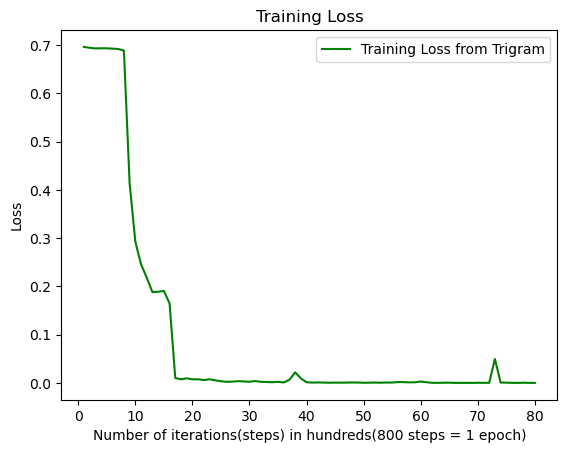

In [54]:
# print(loss_history_trigram)

import matplotlib.pyplot as plt

x_values = range(1,len(loss_history_trigram['train'])+1)
plt.plot(x_values, loss_history_trigram['train'], label="Training Loss from Trigram", color='green')
plt.title("Training Loss")
plt.xlabel("Number of iterations(steps) in hundreds(800 steps = 1 epoch)")
plt.ylabel("Loss")
plt.legend()

plt.show()

Run the code excerpt below if you have trained your model using `trigrams`

**Note**: you should run the testing model that corresponds to your method of training. For example, if you trained your model using bigrams, you should test your model using bigrams. This is to ensure maximum accuracy.

In [55]:
# Create new output file for trigrams
output_path_trigram = "out_trigram.txt"
# load the checkpoint
checkpoint_trigram = torch.load(model_checkpoint_trigram)

# create the test dataset object using SentDataset class
dataset_trigram = SentDataset(x_test, "trigram" , vocab=checkpoint_trigram["vocab"])

# initialize and load the model
num_vocab = dataset_trigram.vocab_size()
model_trigram = Model(num_vocab).to(device)
model_trigram.load_state_dict(checkpoint_trigram["model_state"])

# run the prediction
preds = test(model_trigram, dataset_trigram, 0.5, device)
# write the output
with open(output_path_trigram, 'w', encoding='utf-8') as f:
    f.write('\n'.join(preds))

## Evaluate results of using trigrams instead!

Finally, it is time to evaluate the accuracy of the model trained using trigrams. To do this, we compare the predicted labels against the actual test labels.

In [86]:
with open(output_path_trigram, encoding='utf-8') as f:
    preds = [l.strip() for l in f.readlines()]
with open(y_test, encoding='utf-8') as f:
    labels = [l.strip() for l in f.readlines()]
assert len(preds) == len(labels), "Length of predictions ({}) and labels ({}) are not the same"\
    .format(len(preds), len(labels))

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for pred, label in zip(preds, labels):
    if pred == label and int(pred) == 1:
        true_positive += 1
    elif pred == label and int(pred) == 0:
        true_negative += 1
    elif pred != label and int(pred) == 1:
        false_positive += 1
    elif pred != label and int(pred) == 0:
        false_negative += 1

tri_accuracy = 100.0 * (true_positive + true_negative) / len(labels)
tri_precision = 100.0 * true_positive / (true_positive + false_positive)
tri_recall = 100.0 * true_positive / (true_positive + false_negative)
tri_f1 = 2 * tri_precision * tri_recall / (tri_precision + tri_recall)

print('Accuracy: {:.2f}%'.format(tri_accuracy))
print('Precision: {:.2f}%'.format(tri_precision))
print('Recall: {:.2f}%'.format(tri_recall))
print('F1 score: {:.2f}%'.format(tri_f1))

Accuracy: 86.14%
Precision: 86.92%
Recall: 84.93%
F1 score: 85.92%


## Trying the model with unigram instead as comparison
First, we need to train another model with unigrams.
Run the code excerpt below to train the model using unigrams.

In [60]:
model_checkpoint_unigram = "model_unigram.pt"

if torch.cuda.is_available():
    device_str = 'cuda:{}'.format(0)
else:
    device_str = 'cpu'
    device = torch.device(device_str)

dataset_unigram = SentDataset(x_train, "unigram", y_train)
num_vocab = dataset_unigram.vocab_size()
model_unigram = Model(num_vocab).to(device)

# specify hyper-parameters
batch_size = 48
learning_rate = 0.01
num_epochs = 10

#Loss history
loss_history_unigram = { 'train': [] }

train(model_unigram, dataset_unigram, batch_size, learning_rate, num_epochs, device, model_checkpoint_unigram, loss_history_unigram)

[1,   100] loss: 0.694
[1,   200] loss: 0.694
[1,   300] loss: 0.657
[1,   400] loss: 0.490
[1,   500] loss: 0.410
[1,   600] loss: 0.374
[1,   700] loss: 0.353
[1,   800] loss: 0.328
[2,   100] loss: 0.233
[2,   200] loss: 0.240
[2,   300] loss: 0.208
[2,   400] loss: 0.222
[2,   500] loss: 0.210
[2,   600] loss: 0.211
[2,   700] loss: 0.229
[2,   800] loss: 0.216
[3,   100] loss: 0.105
[3,   200] loss: 0.114
[3,   300] loss: 0.111
[3,   400] loss: 0.107
[3,   500] loss: 0.110
[3,   600] loss: 0.107
[3,   700] loss: 0.115
[3,   800] loss: 0.098
[4,   100] loss: 0.063
[4,   200] loss: 0.052
[4,   300] loss: 0.056
[4,   400] loss: 0.047
[4,   500] loss: 0.046
[4,   600] loss: 0.061
[4,   700] loss: 0.044
[4,   800] loss: 0.050
[5,   100] loss: 0.026
[5,   200] loss: 0.028
[5,   300] loss: 0.021
[5,   400] loss: 0.028
[5,   500] loss: 0.028
[5,   600] loss: 0.020
[5,   700] loss: 0.025
[5,   800] loss: 0.050
[6,   100] loss: 0.017
[6,   200] loss: 0.018
[6,   300] loss: 0.012
[6,   400] 

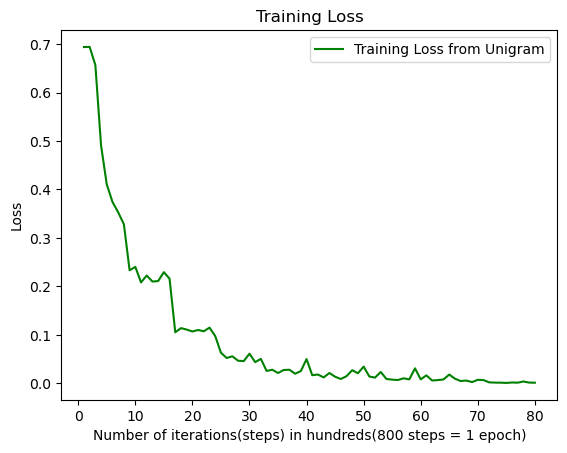

In [61]:


import matplotlib.pyplot as plt

x_values = range(1,len(loss_history_unigram['train'])+1)
plt.plot(x_values, loss_history_unigram['train'], label="Training Loss from Unigram", color='green')
plt.title("Training Loss")
plt.xlabel("Number of iterations(steps) in hundreds(800 steps = 1 epoch)")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [62]:
# Create new output file for trigrams
output_path_unigram = "out_unigram.txt"
# load the checkpoint
checkpoint_unigram = torch.load(model_checkpoint_unigram)

# create the test dataset object using SentDataset class
dataset_unigram = SentDataset(x_test, "unigram" , vocab=checkpoint_unigram["vocab"])

# initialize and load the model
num_vocab = dataset_unigram.vocab_size()
model_unigram = Model(num_vocab).to(device)
model_unigram.load_state_dict(checkpoint_unigram["model_state"])

# run the prediction
preds = test(model_unigram, dataset_unigram, 0.5, device)
# write the output
with open(output_path_unigram, 'w', encoding='utf-8') as f:
    f.write('\n'.join(preds))

Run the code excerpt below if you have trained your model using `unigrams`

**Note**: you should run the testing model that corresponds to your method of training. For example, if you trained your model using unigrams, you should test your model using unigrams. This is to ensure maximum accuracy.

## Evaluate results of using unigrams instead!

Finally, it is time to evaluate the accuracy of the model trained using unigrams. To do this, we compare the predicted labels against the actual test labels.

In [87]:
with open(output_path_unigram, encoding='utf-8') as f:
    preds = [l.strip() for l in f.readlines()]
with open(y_test, encoding='utf-8') as f:
    labels = [l.strip() for l in f.readlines()]
assert len(preds) == len(labels), "Length of predictions ({}) and labels ({}) are not the same"\
    .format(len(preds), len(labels))

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for pred, label in zip(preds, labels):
    if pred == label and int(pred) == 1:
        true_positive += 1
    elif pred == label and int(pred) == 0:
        true_negative += 1
    elif pred != label and int(pred) == 1:
        false_positive += 1
    elif pred != label and int(pred) == 0:
        false_negative += 1

uni_accuracy = 100.0 * (true_positive + true_negative) / len(labels)
uni_precision = 100.0 * true_positive / (true_positive + false_positive)
uni_recall = 100.0 * true_positive / (true_positive + false_negative)
uni_f1 = 2 * uni_precision * uni_recall / (uni_precision + uni_recall)

print('Accuracy: {:.2f}%'.format(uni_accuracy))
print('Precision: {:.2f}%'.format(uni_precision))
print('Recall: {:.2f}%'.format(uni_recall))
print('F1 score: {:.2f}%'.format(uni_f1))

Accuracy: 86.26%
Precision: 81.58%
Recall: 93.51%
F1 score: 87.14%


# Conclusion of results



## 1. Plotting training loss against number of iterations for different n-grams used

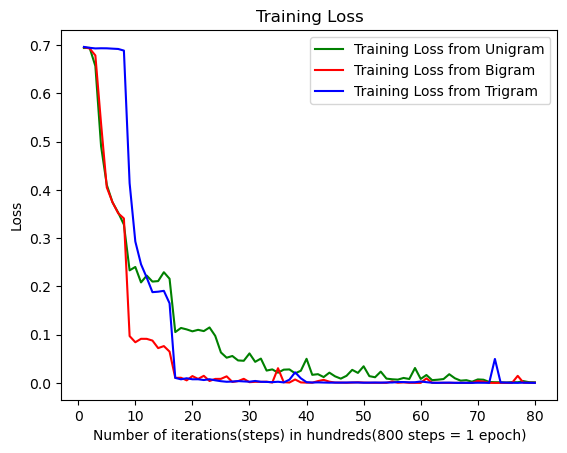

In [65]:
import matplotlib.pyplot as plt

x1_values = range(1,len(loss_history_unigram['train'])+1)
plt.plot(x_values, loss_history_unigram['train'], label="Training Loss from Unigram", color='green')

x2_values = range(1,len(loss_history['train'])+1)
plt.plot(x2_values, loss_history['train'], label="Training Loss from Bigram", color='red')

x3_values = range(1,len(loss_history_trigram['train'])+1)
plt.plot(x3_values, loss_history_trigram['train'], label="Training Loss from Trigram", color='blue')

plt.title("Training Loss")
plt.xlabel("Number of iterations(steps) in hundreds(800 steps = 1 epoch)")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Which is better?

From the plotted graph above, we observe a slight disparity in the convergence rates among the models that were trained using bigrams and trigrams, in contrast to the model trained exclusively with unigrams. 

Models that used bigrams and trigrams reached convergence in a smaller number of iterations than that of unigrams.

This difference can be attributed to the limitations of the unigram model in capturing neighbouring word relationships and contextual nuances. In contrast, the models that used bigrams and trigrams displayed a greater capacity to address the complex relationships within the data in a shorter time.

## 2. Tabulating evaluation metrics of the models

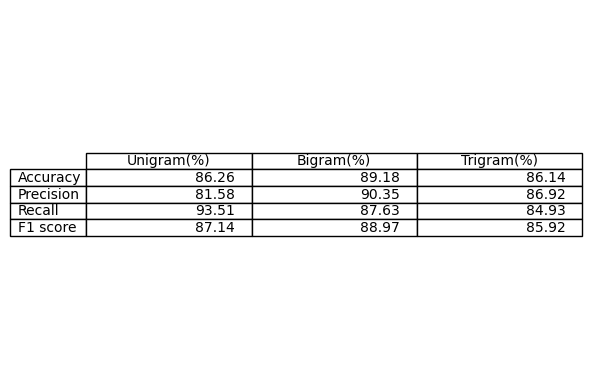

In [92]:
import matplotlib.pylab as plt
import numpy as np

data = np.round(np.array(
        [[ uni_accuracy, bi_accuracy,  tri_accuracy],
        [ uni_precision, bi_precision,  tri_precision],
        [ uni_recall,  bi_recall, tri_recall],
        [ uni_f1,  bi_f1, tri_f1]]), 2)

columns = ('Unigram(%)', 'Bigram(%)', 'Trigram(%)')
rows = ('Accuracy', 'Precision', 'Recall', 'F1 score')

fig, axs = plt.subplots(1, 1)
axs.axis('off')

the_table = axs.table(cellText=data,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')



### Which is better?

Overall, models that employed bigrams performed the best in terms of accuracy and F1 score. This may be attributed to a few factors:

#### **1. Higher Discriminatory Power**

 Compared to unigrams, bigrams help the model better distinguish between differences in sentiment. 
 
 For example, phrases like "not good" and "very good" would be treated differently, as the bigram "not good" is more indicative of a negative sentiment. While unigrams look at individual words and fail to detect this relationship, bigrams are able to capture it well. This increased discriminatory power contributes to the model's accuracy.

#### **2. Balancing Specificity and Generality**

Compared to trigrams, bigrams able to strike a balance between capturing complex relationships between words and not overfitting the data. 

Trigrams, with their longer word sequences, can capture more context but may also introduce noise and increase sparsity of the vocabulary. Three-worded phrases may be less commonly spotted in the dataset, causing there to be many unique trigrams in the vocabulary that may not appear frequently in the dataset. This results in a sparse vocabulary, where the majority of trigrams are sparsely represented or occur only once or a few times. The model may struggle to generalize effectively, potentially leading to overfitting. 

On the other hand, bigrams strike a balance between specificity and generality, allowing the model to capture relevant context without overwhelming it.
